# Surface Meshing

In [1]:
import build123d as bd
import stellarmesh as sm
from IPython.display import Image
import logging
import tempfile

/home/alex/Programming/stellarmesh/.pixi/envs/build123d/lib/python3.11/site-packages/pymoab/__init__.py:21: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


In [2]:
def render_mesh(mesh: sm.Mesh):
    with tempfile.NamedTemporaryFile(suffix=".png", delete=False) as tmp_file:
        mesh.render(tmp_file.name, rotation_xyz=(90, 0, -90), normals=0, clipping=True)
        display(Image(tmp_file.name, width=800))

## Model Geometry

In [3]:
def build_torus_geometry():
    solids = [bd.Solid.make_torus(10, 1)]
    for _ in range(2):
        solids.append(bd.thicken(solids[-1].faces()[0], 1))
    solids = solids[1:]
    return sm.Geometry(solids, material_names=["a", "b"])

## Mesh With OCC

X_ChangeProperty: BadValue (integer parameter out of range for operation) 0x0


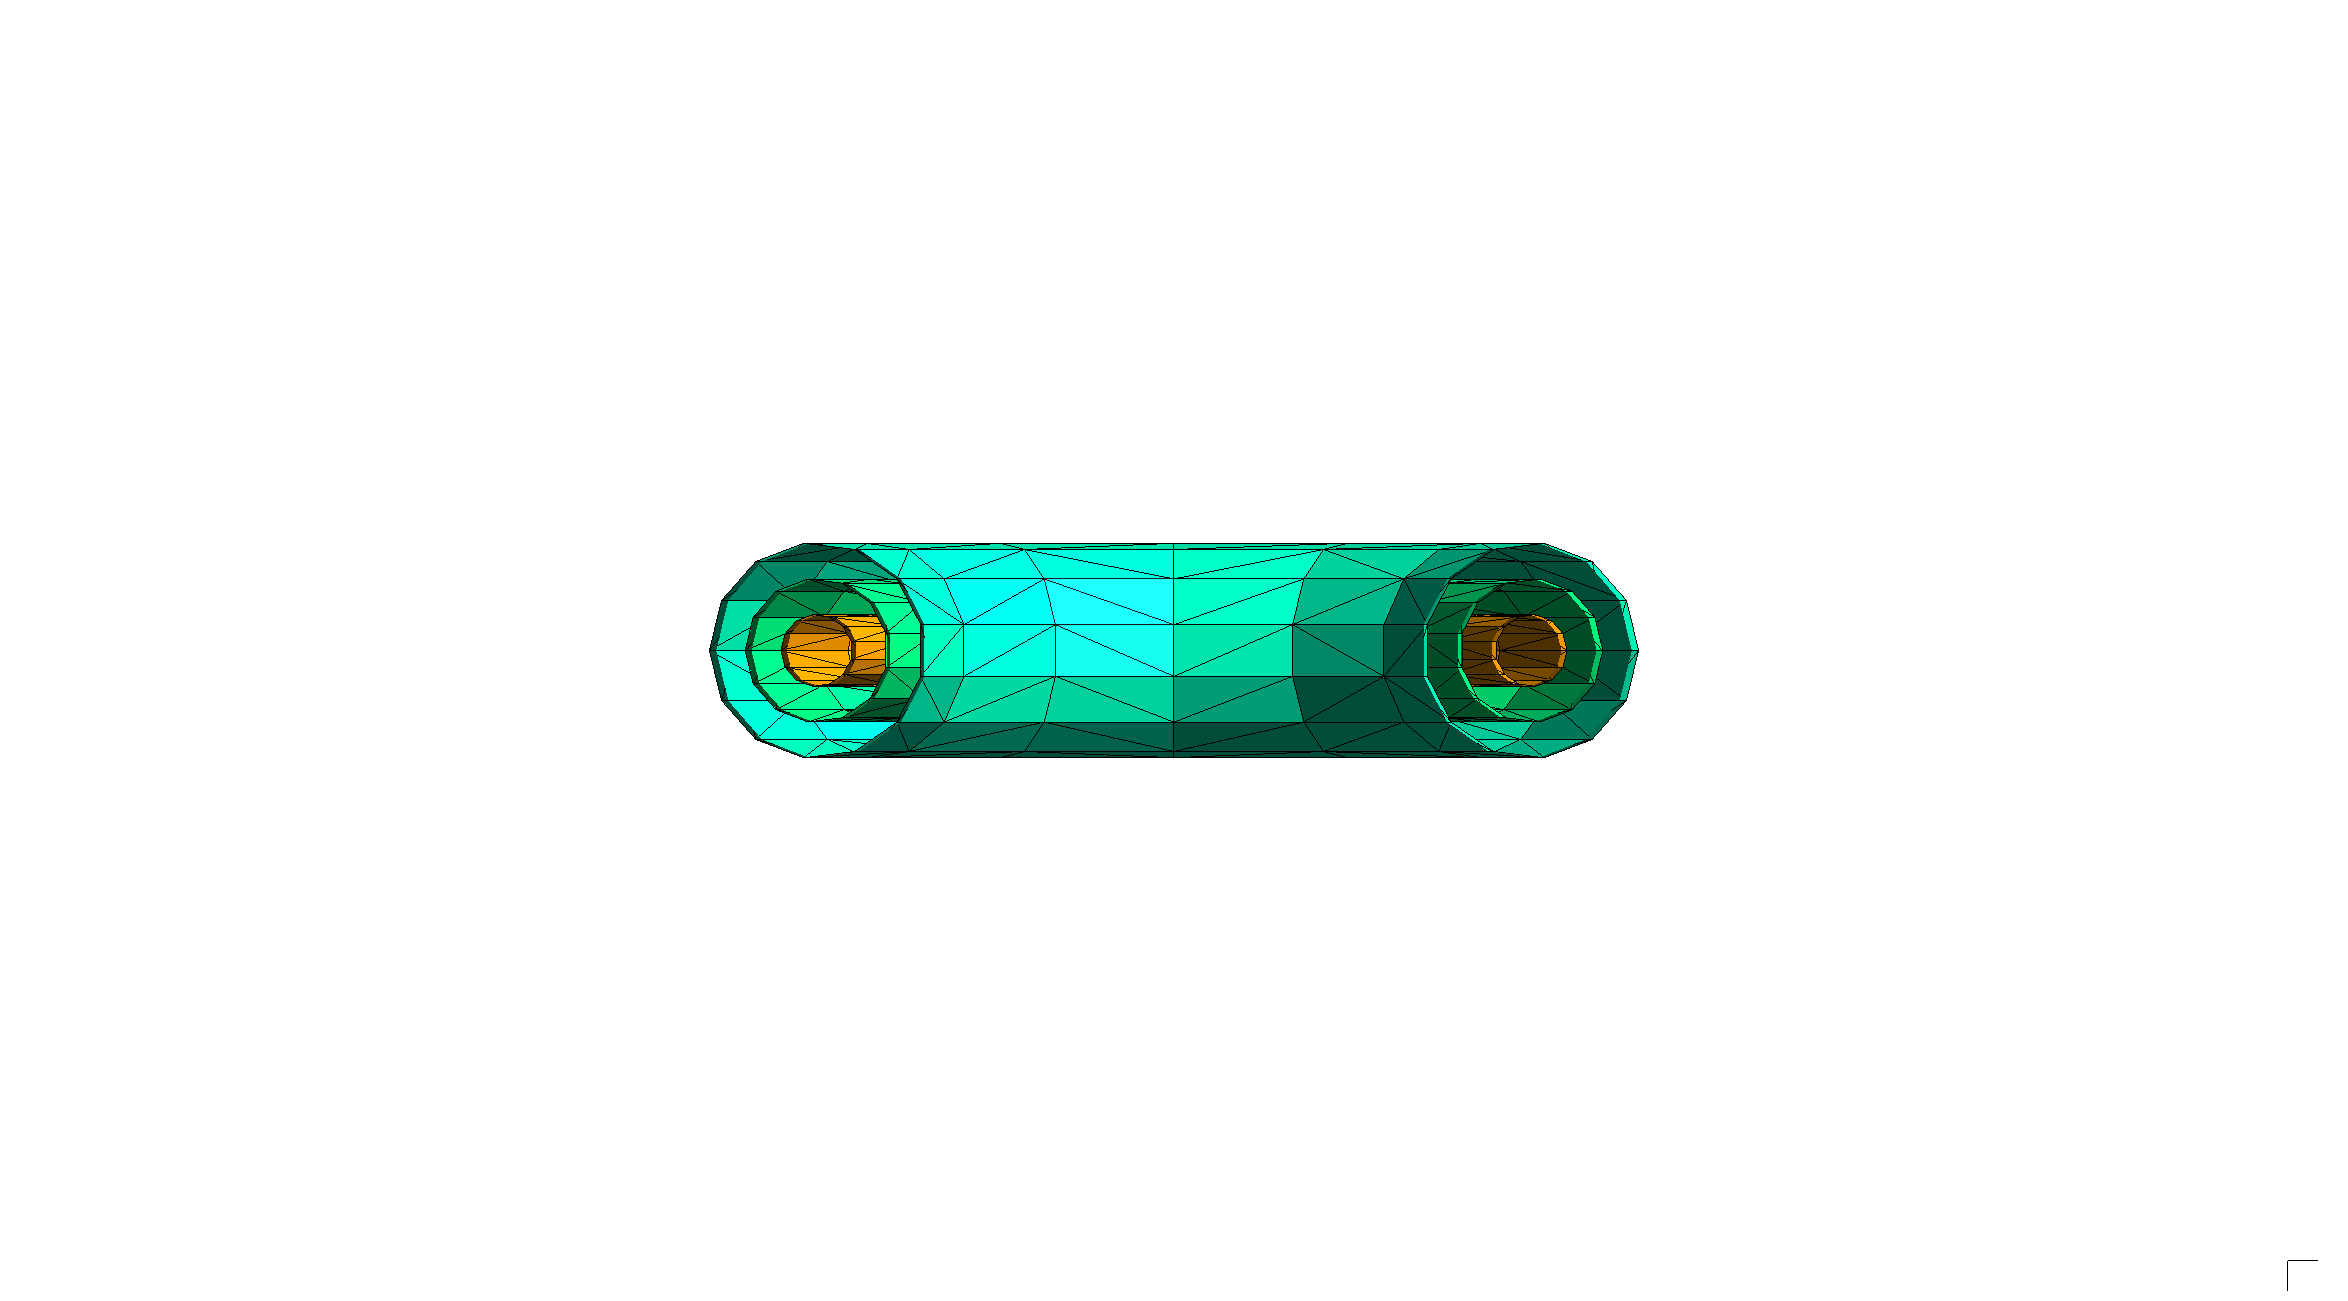

In [4]:
geometry = build_torus_geometry()
meshing_options = sm.OCCSurfaceOptions(tol_angular_deg=1, tol_linear=None)
mesh = sm.SurfaceMesh.from_geometry(geometry, meshing_options)
render_mesh(mesh)

X_ChangeProperty: BadValue (integer parameter out of range for operation) 0x0


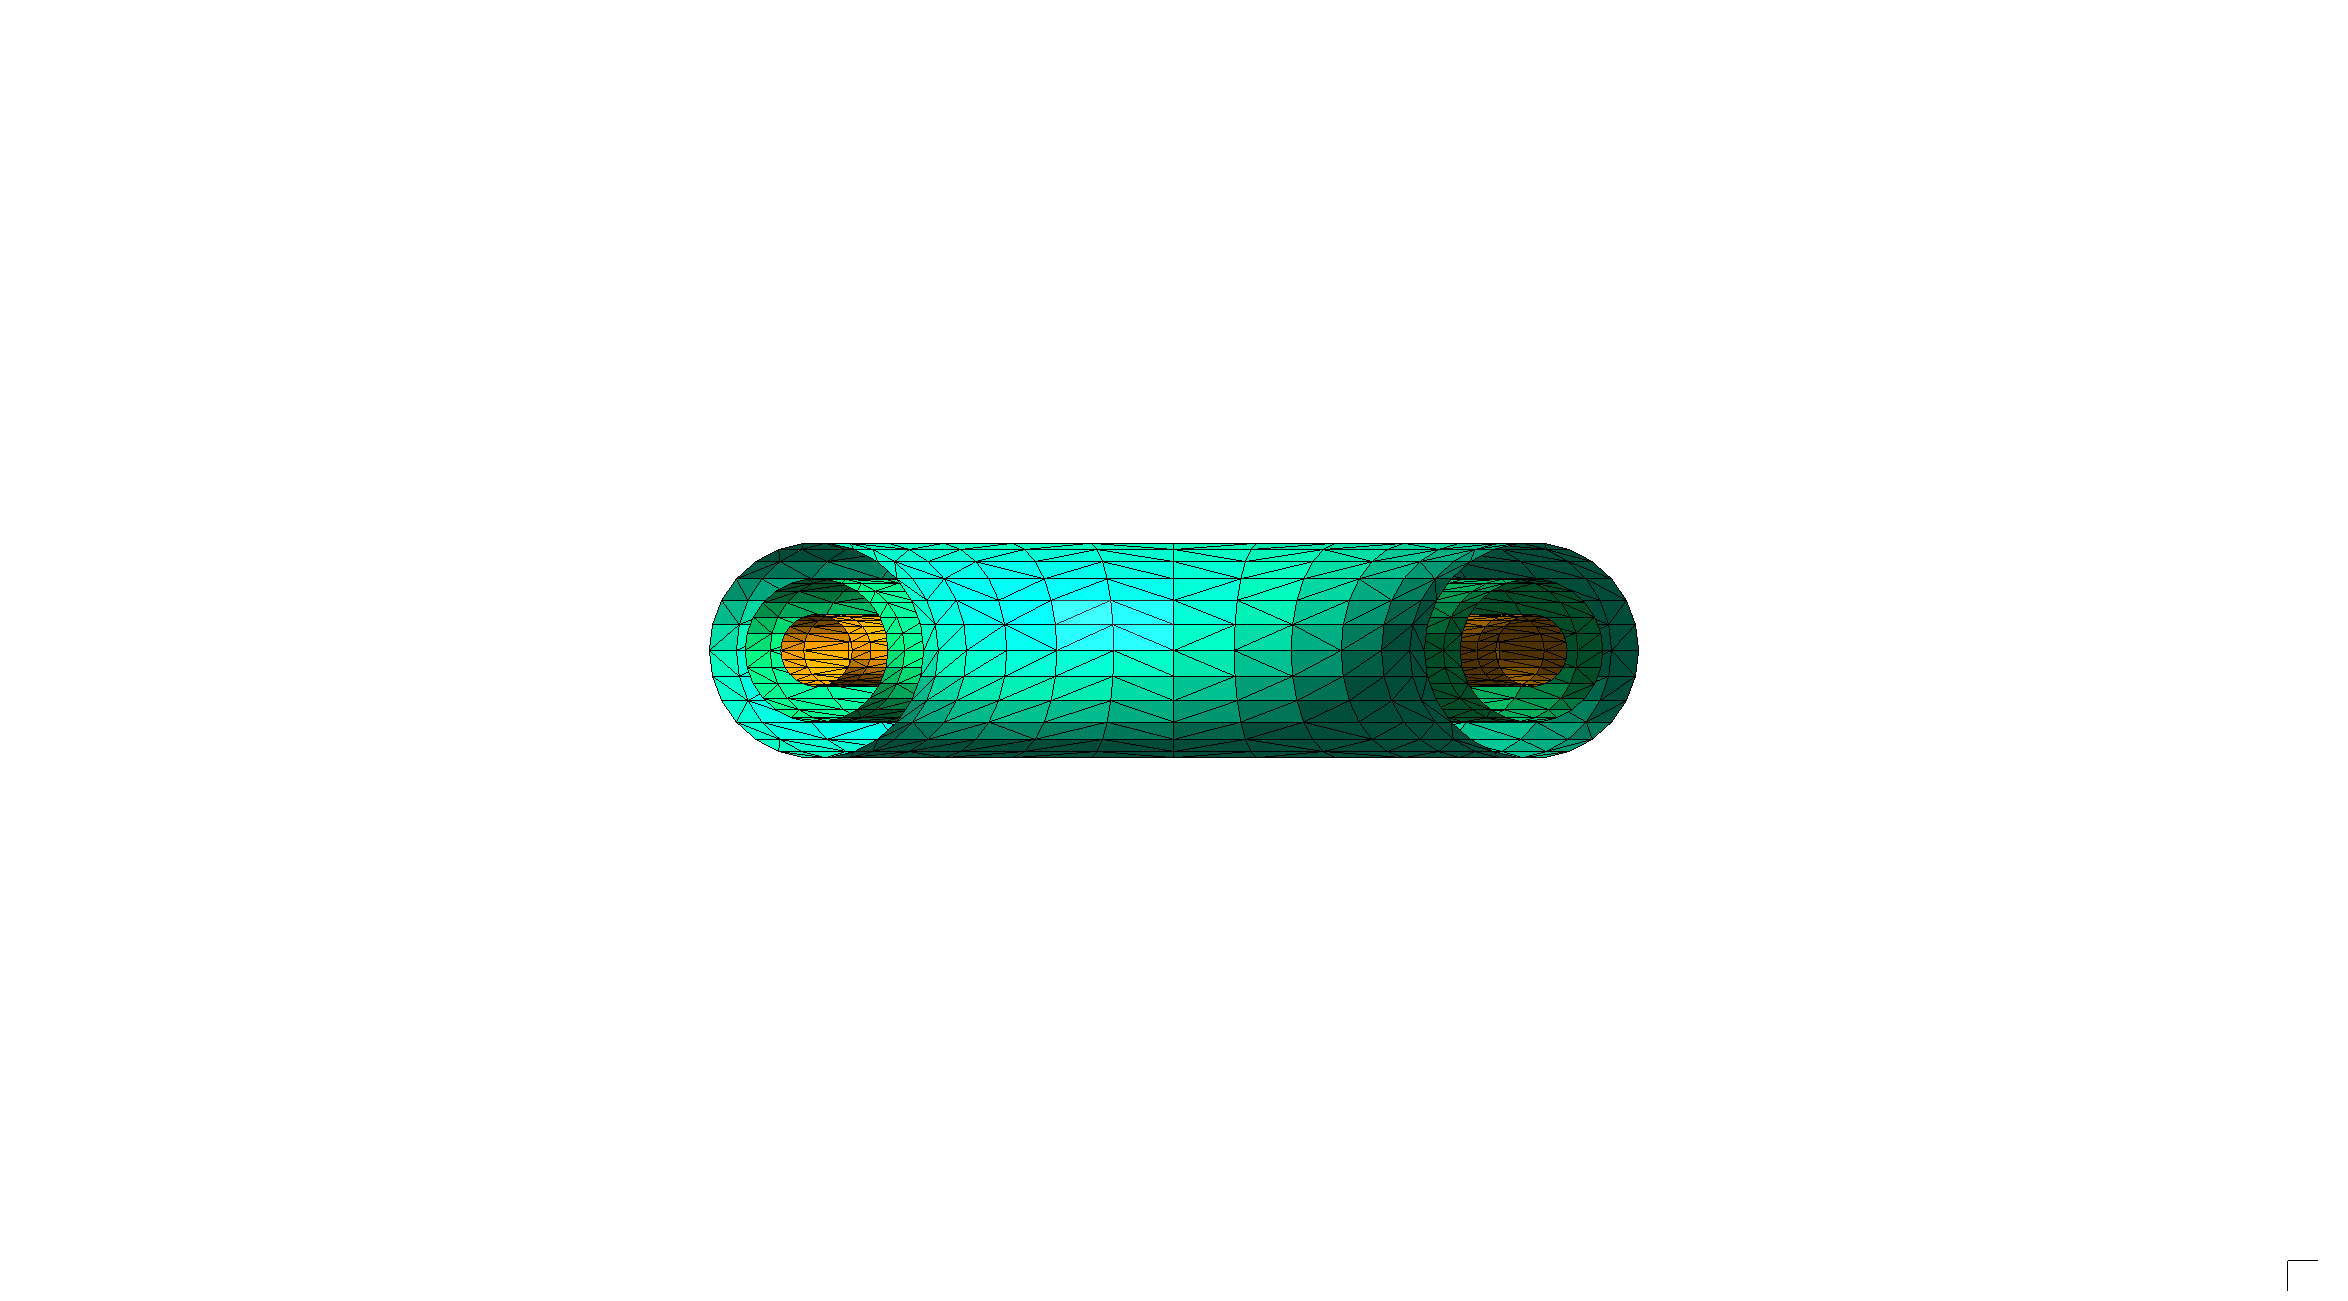

In [5]:
geometry = build_torus_geometry()
meshing_options = sm.OCCSurfaceOptions(tol_angular_deg=0.5, tol_linear=None)
mesh = sm.SurfaceMesh.from_geometry(geometry, meshing_options)
render_mesh(mesh)

### Linear tolerance

X_ChangeProperty: BadValue (integer parameter out of range for operation) 0x0


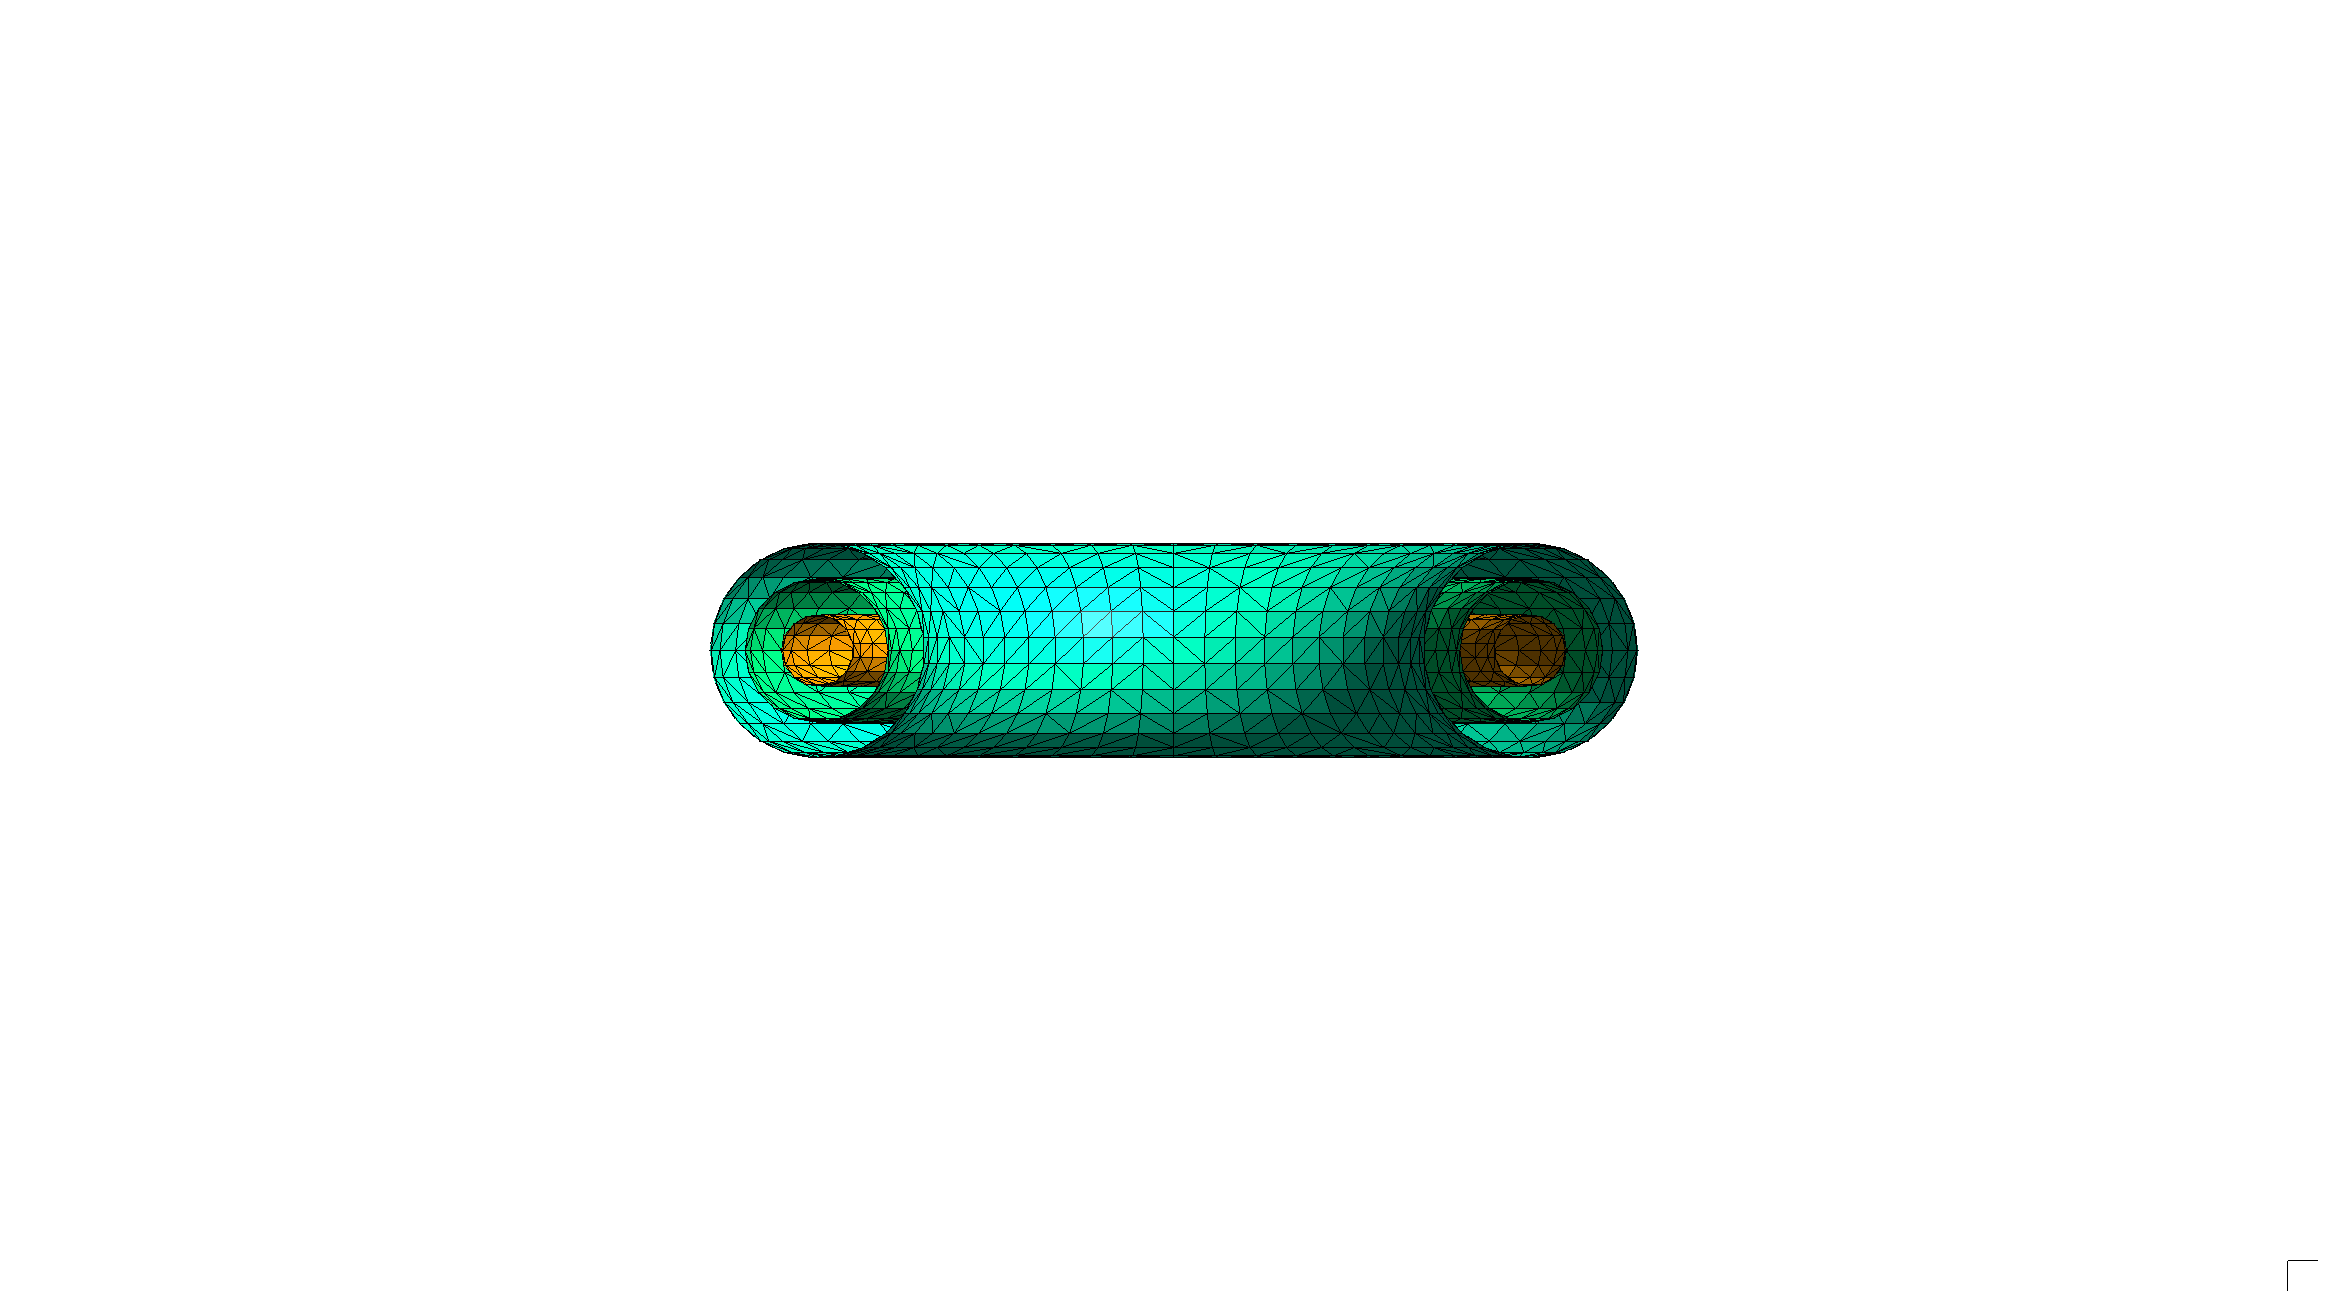

In [6]:
geometry = build_torus_geometry()
meshing_options = sm.OCCSurfaceOptions(tol_angular_deg=None, tol_linear=0.05)
mesh = sm.SurfaceMesh.from_geometry(geometry, meshing_options)
render_mesh(mesh)

## Mesh With Gmsh

It is also possible to mesh geometries using Gmsh surface meshing algorithms. These algorithms generate high quality elements. However, while Gmsh does support angular tolerances, linear tolerances are not supported.

X_ChangeProperty: BadValue (integer parameter out of range for operation) 0x0


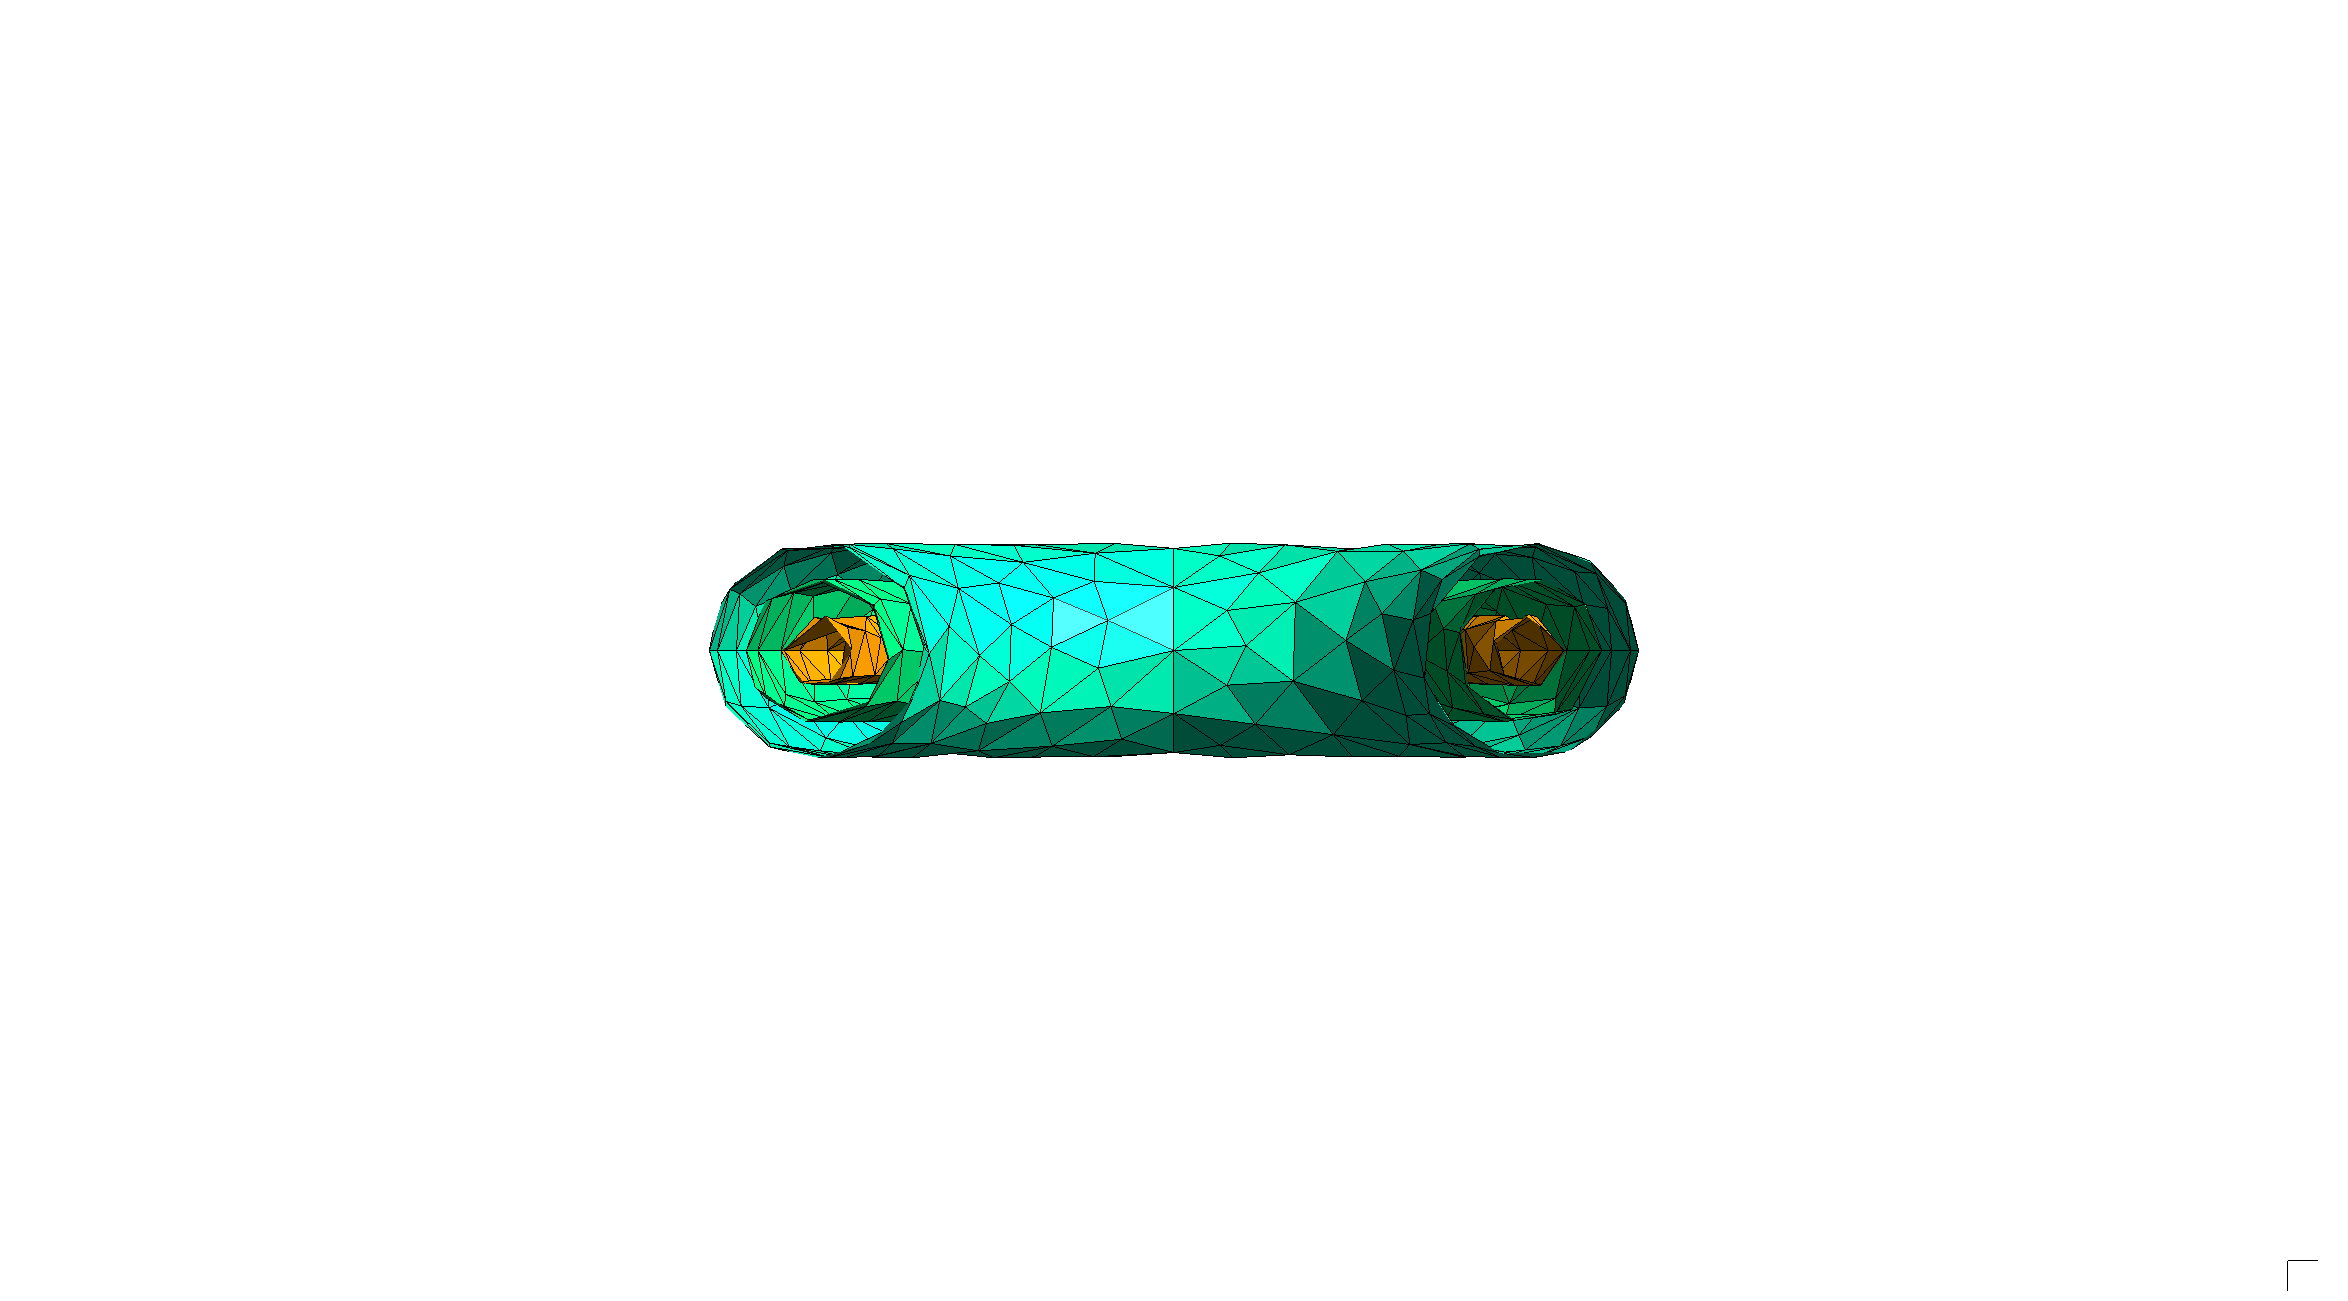

In [7]:
geometry = build_torus_geometry()
meshing_options = sm.GmshSurfaceOptions(min_mesh_size=0.5, max_mesh_size=2)
mesh = sm.SurfaceMesh.from_geometry(geometry, meshing_options)
mesh.render("mesh.png", rotation_xyz=(90, 0, -90), normals=0, clipping=True)
display(Image("mesh.png", width=800))

X_ChangeProperty: BadValue (integer parameter out of range for operation) 0x0


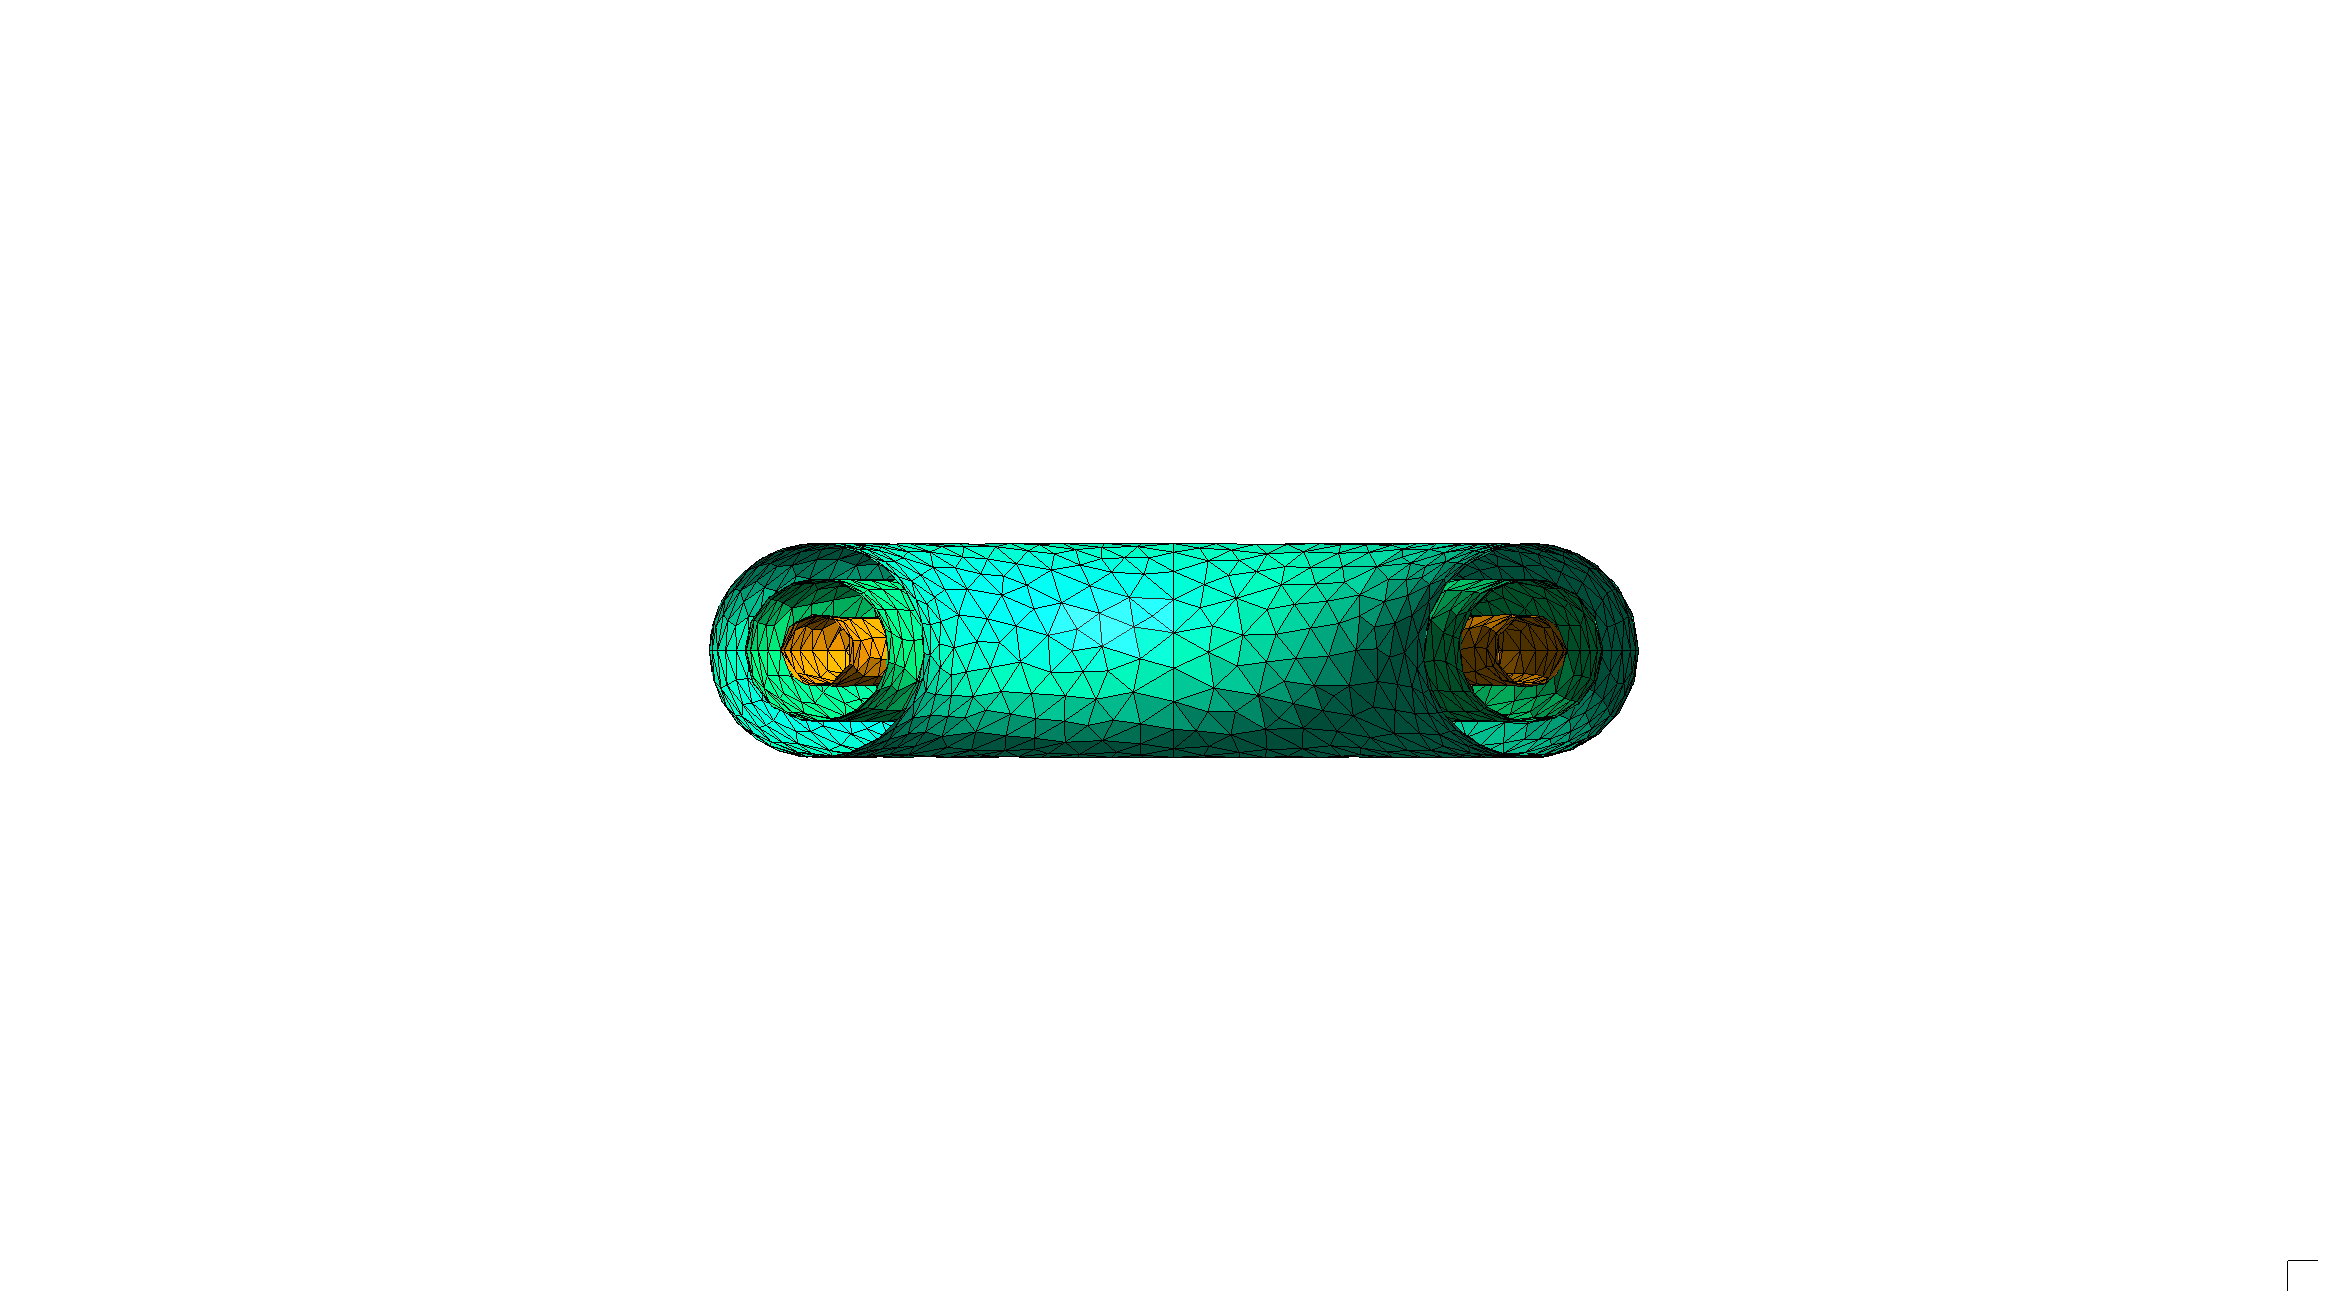

In [8]:
geometry = build_torus_geometry()
meshing_options = sm.GmshSurfaceOptions(min_mesh_size=0.5, max_mesh_size=1)
mesh = sm.SurfaceMesh.from_geometry(geometry, meshing_options)
mesh.render("mesh.png", rotation_xyz=(90, 0, -90), normals=0, clipping=True)

display(Image("mesh.png", width=800))

### Curvature Target

The `curvature_target` option allows us to specify a target number of mesh elements per 2pi radians. Note that regions of higher curvature now have a finer mesh resolution.

X_ChangeProperty: BadValue (integer parameter out of range for operation) 0x0


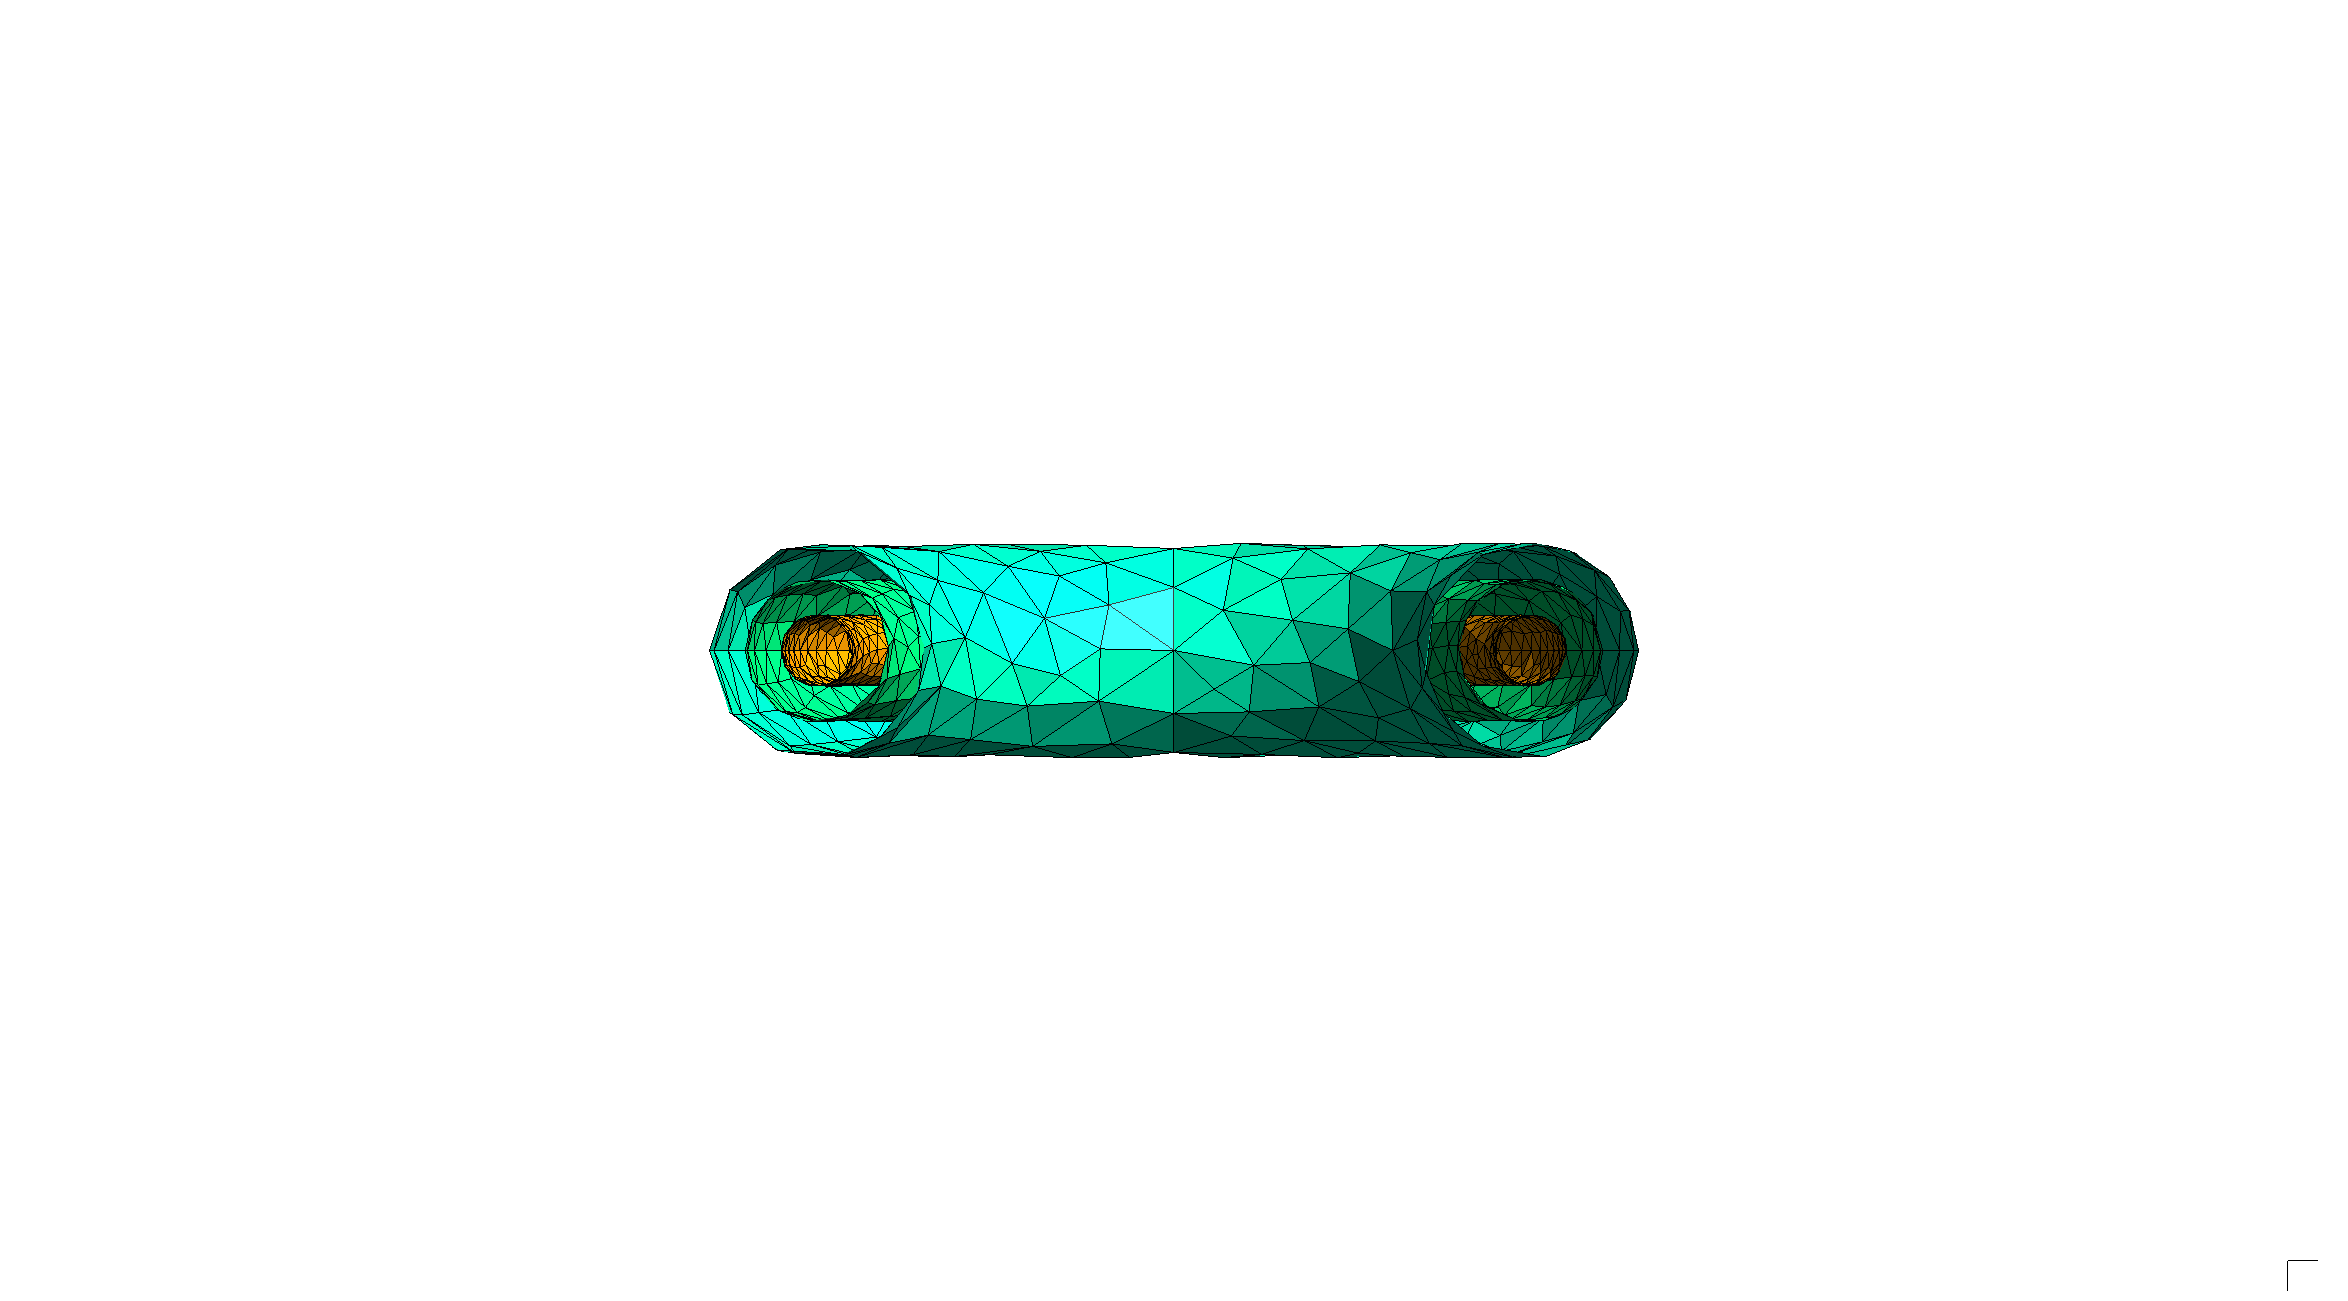

In [9]:
geometry = build_torus_geometry()
meshing_options = sm.GmshSurfaceOptions(curvature_target=10)
mesh = sm.SurfaceMesh.from_geometry(geometry, meshing_options)
mesh.render("mesh.png", rotation_xyz=(90, 0, -90), normals=0, clipping=True)

display(Image("mesh.png", width=800))

## Run an OpenMC Tally

In [ ]:
import tempfile
from pathlib import Path

import build123d as bd
import numpy as np
import openmc
import openmc.stats

import stellarmesh as sm

with tempfile.TemporaryDirectory() as tmpdirname:
    tmp_path = Path(tmpdirname)

    geometry = build_torus_geometry()
    mesh = sm.SurfaceMesh.from_geometry(
        geometry, sm.OCCSurfaceOptions(tol_angular_deg=0.5)
    )
    dagmc_model = sm.DAGMCModel.from_mesh(mesh)
    dagmc_model.write(tmp_path / "dagmc.h5m")

    mat1 = openmc.Material(name="a")
    mat1.add_nuclide("Fe56", 1)
    mat1.set_density("g/cm3", 1)
    mat2 = openmc.Material(name="b")
    mat2.add_nuclide("Be9", 1)
    mat2.set_density("g/cm3", 1)
    materials = openmc.Materials([mat1, mat2])

    universe = openmc.DAGMCUniverse(tmp_path / "dagmc.h5m").bounded_universe()
    openmc_geometry = openmc.Geometry(universe)

    source = openmc.IndependentSource()
    source.space = openmc.stats.CylindricalIndependent(
        openmc.stats.Discrete([10], [1]),
        openmc.stats.Uniform(0, 2 * np.pi),
        openmc.stats.Discrete([0], [1]),
    )
    source.energy = openmc.stats.Discrete([14e6], [1])

    settings = openmc.Settings()
    settings.batches = 5
    settings.inactive = 0
    settings.particles = 100
    settings.run_mode = "fixed source"
    settings.source = source

    mat_filter = openmc.MaterialFilter(materials)
    tally = openmc.Tally(name="flux")
    tally.filters = [mat_filter]
    tally.scores = ["flux"]
    tallies = openmc.Tallies([tally])

    model = openmc.Model(openmc_geometry, materials, settings, tallies)
    model.export_to_model_xml(path=tmp_path)
    output_file = model.run(cwd=str(tmp_path))
    with openmc.StatePoint(output_file) as sp:
        tally = sp.get_tally(name="flux")
        flux = tally.mean.flatten()
        print("Flux:", flux)

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################